# Exploratory analysis of the results

Use ArviZ to explore and analyze the results of the PPLs. We will randomly load any of the 3 examples and run the code below. Thanks to the `InferenceData` schema, all the code below is completely agnostic with respect to the PPL and programming language used to generate the data.

We start importing libraries and making sure we are using the latest ArviZ release.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
az.__version__

'0.10.0'

We will now make our 3 examples: PyMC3, PyStan and Soss generated data, available to ArviZ. This will take care of downloading from figshare, checking the checksum and caching the downloaded files.

In [4]:
import arviz.data.datasets as azd

azd.REMOTE_DATASETS.update({
    "soss_probprog": azd.RemoteFileMetadata(
        filename="soss.nc",
        url="http://ndownloader.figshare.com/files/25082627",
        checksum="aa9185c1365d92057e6007f151f24db0a7b0bf8808b01b5c57b49744546a96ee",
        description="""Soss implementation"""
    ),
    "pymc3_probprog": azd.RemoteFileMetadata(
        filename="pymc3.nc",
        url="http://ndownloader.figshare.com/files/25080479",
        checksum="def4b8eb03bb5b592d12f952abf73863bae401368b23e01b67e374042b2e531d",
        description="""PyMC3 implementation"""
    ),
    "pystan_probprog": azd.RemoteFileMetadata(
        filename="pystan.nc",
        url="http://ndownloader.figshare.com/files/25080545",
        checksum="6f1d76d5dde10af910a1507584a886da16138f1bb78856b21abee44b7ec99460",
        description="""PyStan implementation"""
    )
})

In [5]:
examples = ("soss", "pystan", "pymc3")

Before doing any further analysis, we will compare the posteriors of all 3 PPLs to make sure we have indeed implemented the same model in all 3 frameworks.

/home/oriol/miniconda3/envs/arviz/lib/python3.8/site-packages/arviz/plots/densityplot.py:199: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (90) in plot_density, generating only 40 plots
  warnings.warn(


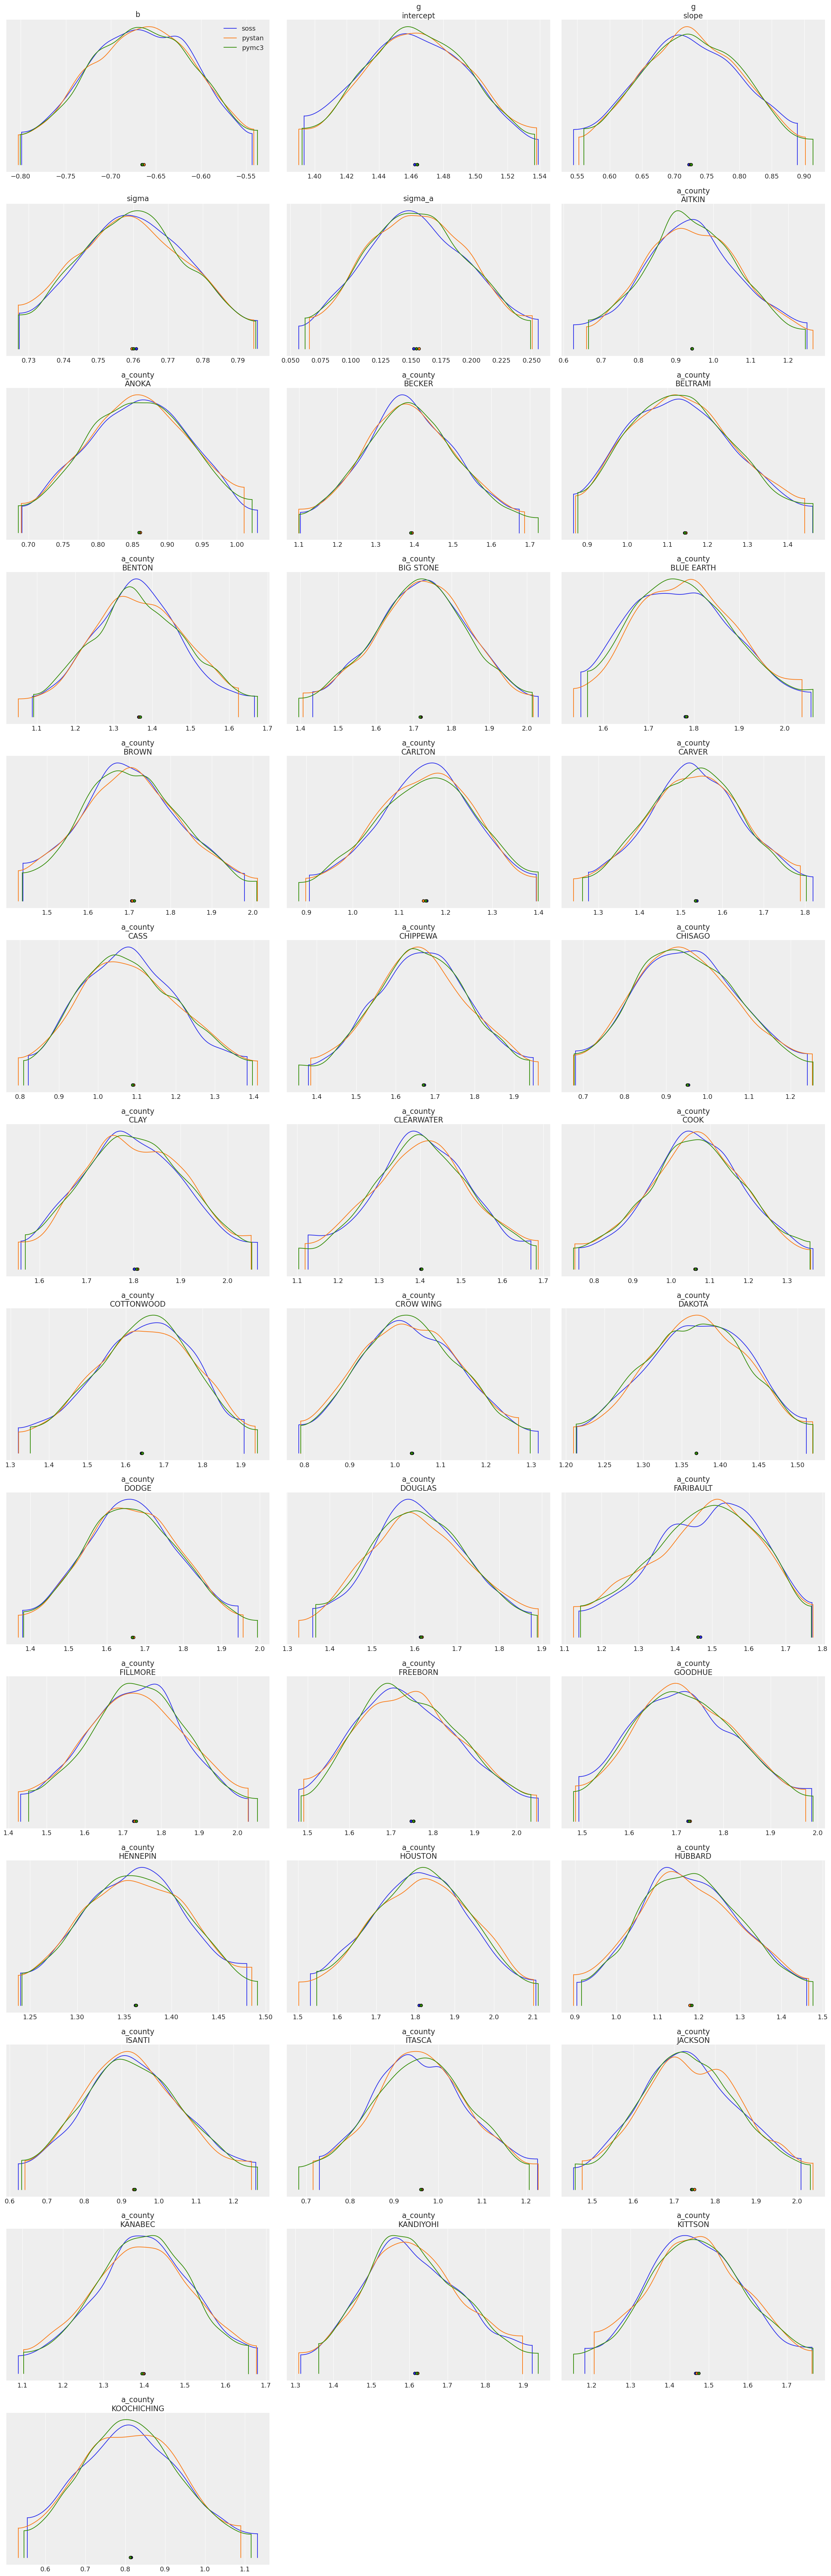

In [6]:
az.plot_density(
    [az.load_arviz_data(f"{lib}_probprog") for lib in examples], 
    var_names=("b", "g", "sigma", "sigma_a", "a_county"),
    data_labels=examples,
);

Now we will choose a PPL at random and perfom all the analysis with it.

In [7]:
lib = rng.choice(examples)
idata = az.load_arviz_data(f"{lib}_probprog")
if lib == "soss":
    idata.constant_data["county_idx"] = idata.constant_data["county_idx"] - 1
print(lib)

soss


# Diagnostics

In [8]:
az.summary(idata, var_names=["g", "b"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
g[0]  1.462  0.040   1.393    1.539      0.001    0.001    2120.0  2119.0   
g[1]  0.722  0.095   0.544    0.890      0.002    0.002    1998.0  1939.0   
b    -0.666  0.069  -0.799   -0.543      0.001    0.001    3056.0  3056.0   

      ess_bulk  ess_tail  r_hat  
g[0]    2127.0    1804.0    1.0  
g[1]    2015.0    1527.0    1.0  
b       3034.0    1486.0    1.0

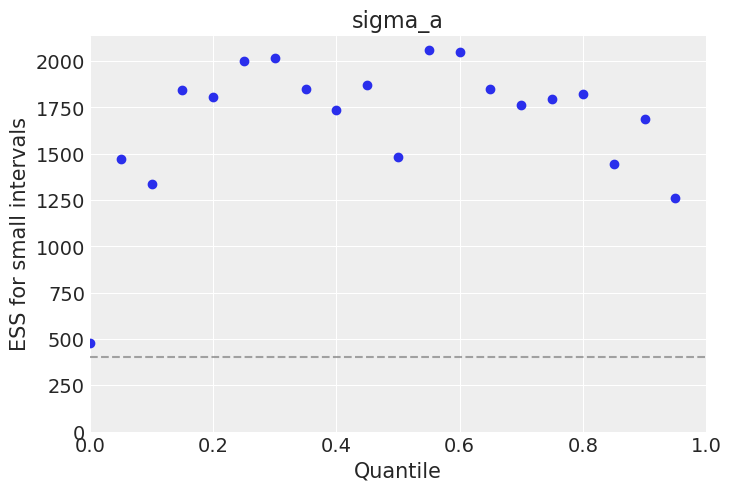

In [9]:
az.plot_ess(idata, var_names=["sigma_a"]);

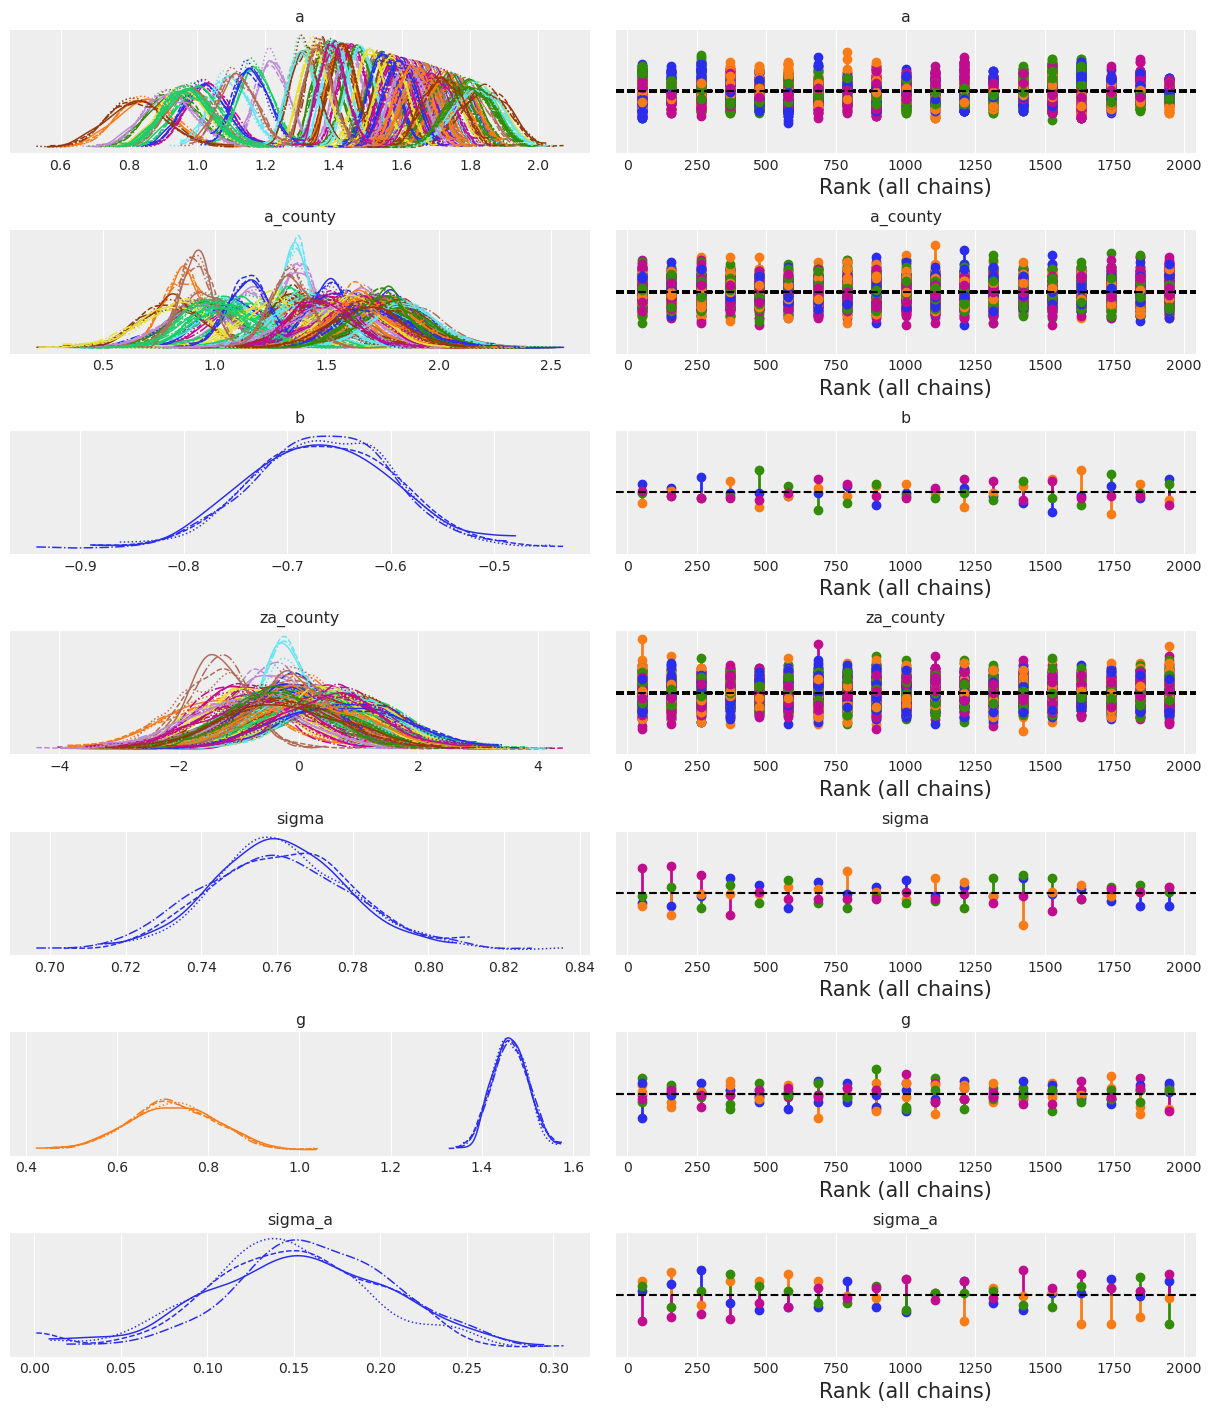

In [10]:
az.plot_trace(idata, var_names="~theta", kind="rank_vlines", compact=True);

# Model comparison

ArviZ also allows to modify pointwise log likelihood data to allow estimating cross-validation with PSIS for hierarchical models or multiple likelihoods. 

Let's calculate both leave one out and leave one group out cross-validation:

In [11]:
log_lik = idata.log_likelihood
const = idata.constant_data
county_names = idata.posterior["county"][const["county_idx"]]
log_lik["by_county"] = log_lik["y"].groupby(county_names).sum()

In [12]:
az.loo(idata, pointwise=True, var_name="y")

Computed from 2000 by 919 log-likelihood matrix

         Estimate       SE
elpd_loo -1064.66    29.17
p_loo       25.86        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      919  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [13]:
loo_county = az.loo(idata, pointwise=True, var_name="by_county")
loo_county

/home/oriol/miniconda3/envs/arviz/lib/python3.8/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 by 85 log-likelihood matrix

         Estimate       SE
elpd_loo -1065.51   191.26
p_loo       23.42        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       63   74.1%
 (0.5, 0.7]   (ok)         17   20.0%
   (0.7, 1]   (bad)         5    5.9%
   (1, Inf)   (very bad)    0    0.0%

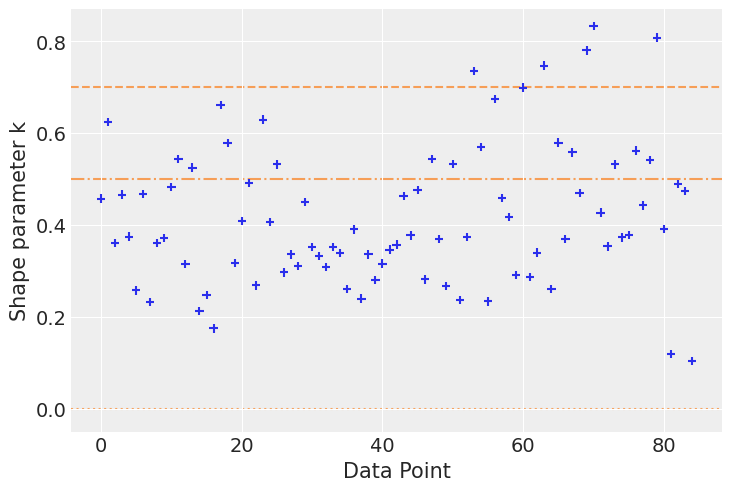

In [14]:
az.plot_khat(loo_county);

# Model criticism

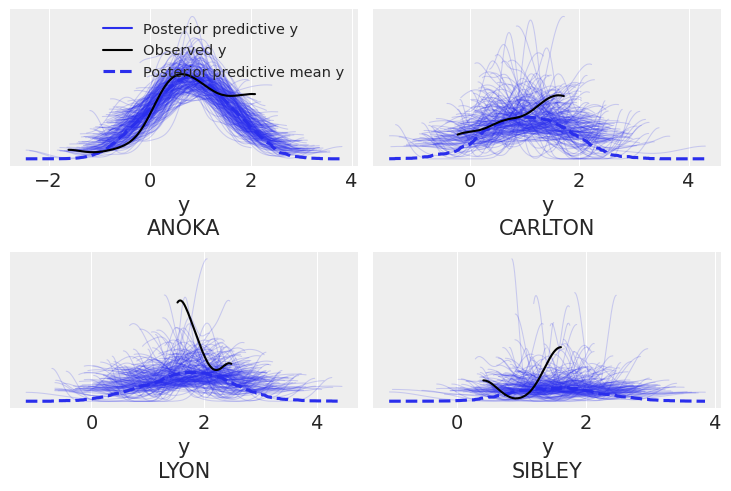

In [15]:
_, ax = plt.subplots(2,2)
obs_county = idata.posterior["county"][idata.constant_data["county_idx"]]
az.plot_ppc(
    idata.assign_coords(obs_id=obs_county, groups="observed_vars"), 
    coords={'obs_id': ['ANOKA', 'CARLTON', 'LYON', 'SIBLEY']}, 
    flatten=[],
    num_pp_samples=200,
    ax=ax
);

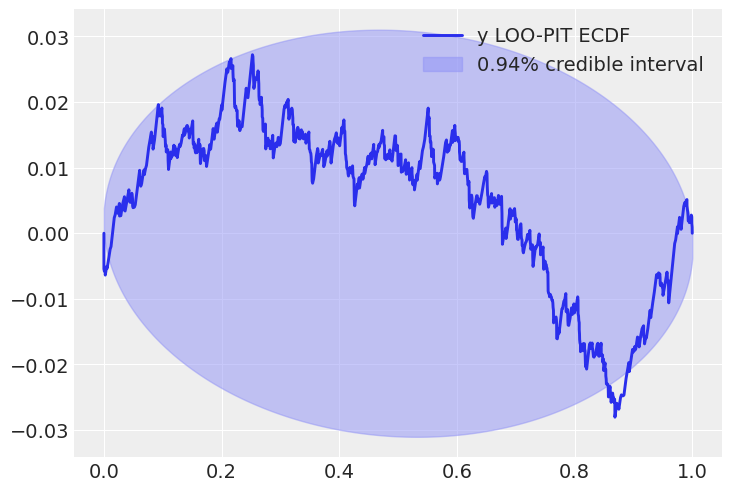

In [16]:
az.plot_loo_pit(idata, y="y", ecdf=True);

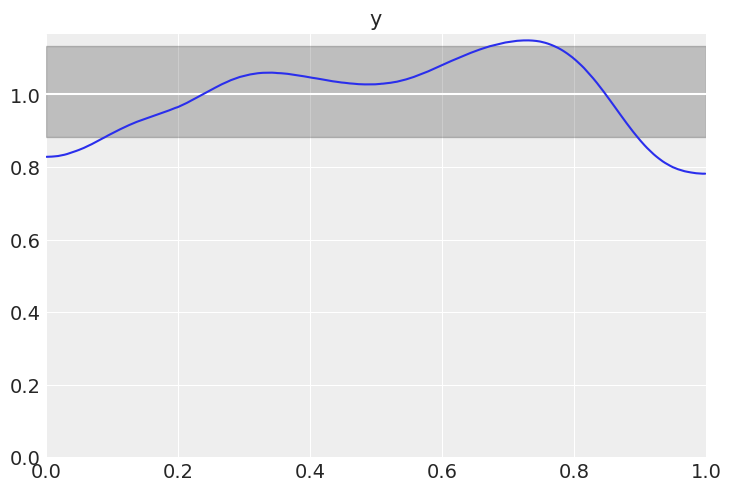

In [17]:
az.plot_bpv(idata);

# Model exploration

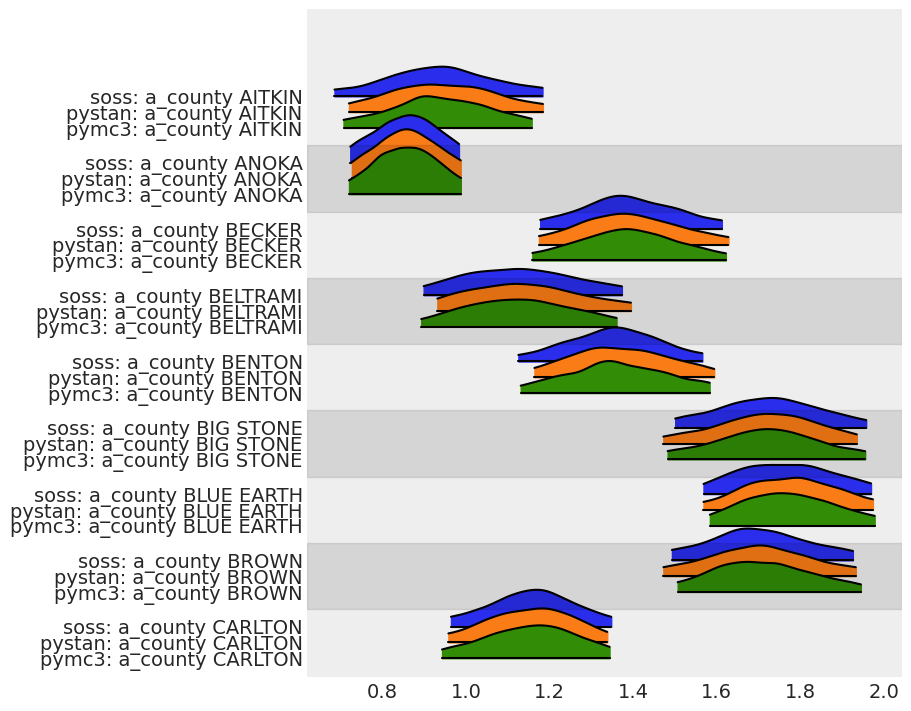

In [19]:
az.plot_forest(
    [az.load_arviz_data(f"{lib}_probprog") for lib in examples],
    coords={"county": slice("AITKIN", "CARLTON")},
    model_names=examples,
    var_names="a_county",
    kind='ridgeplot',
    combined=True,
    hdi_prob=.87,
    ridgeplot_overlap=3.5,
    ridgeplot_truncate=True,
    figsize=(9, 7)
);

/home/oriol/miniconda3/envs/arviz/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:236: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


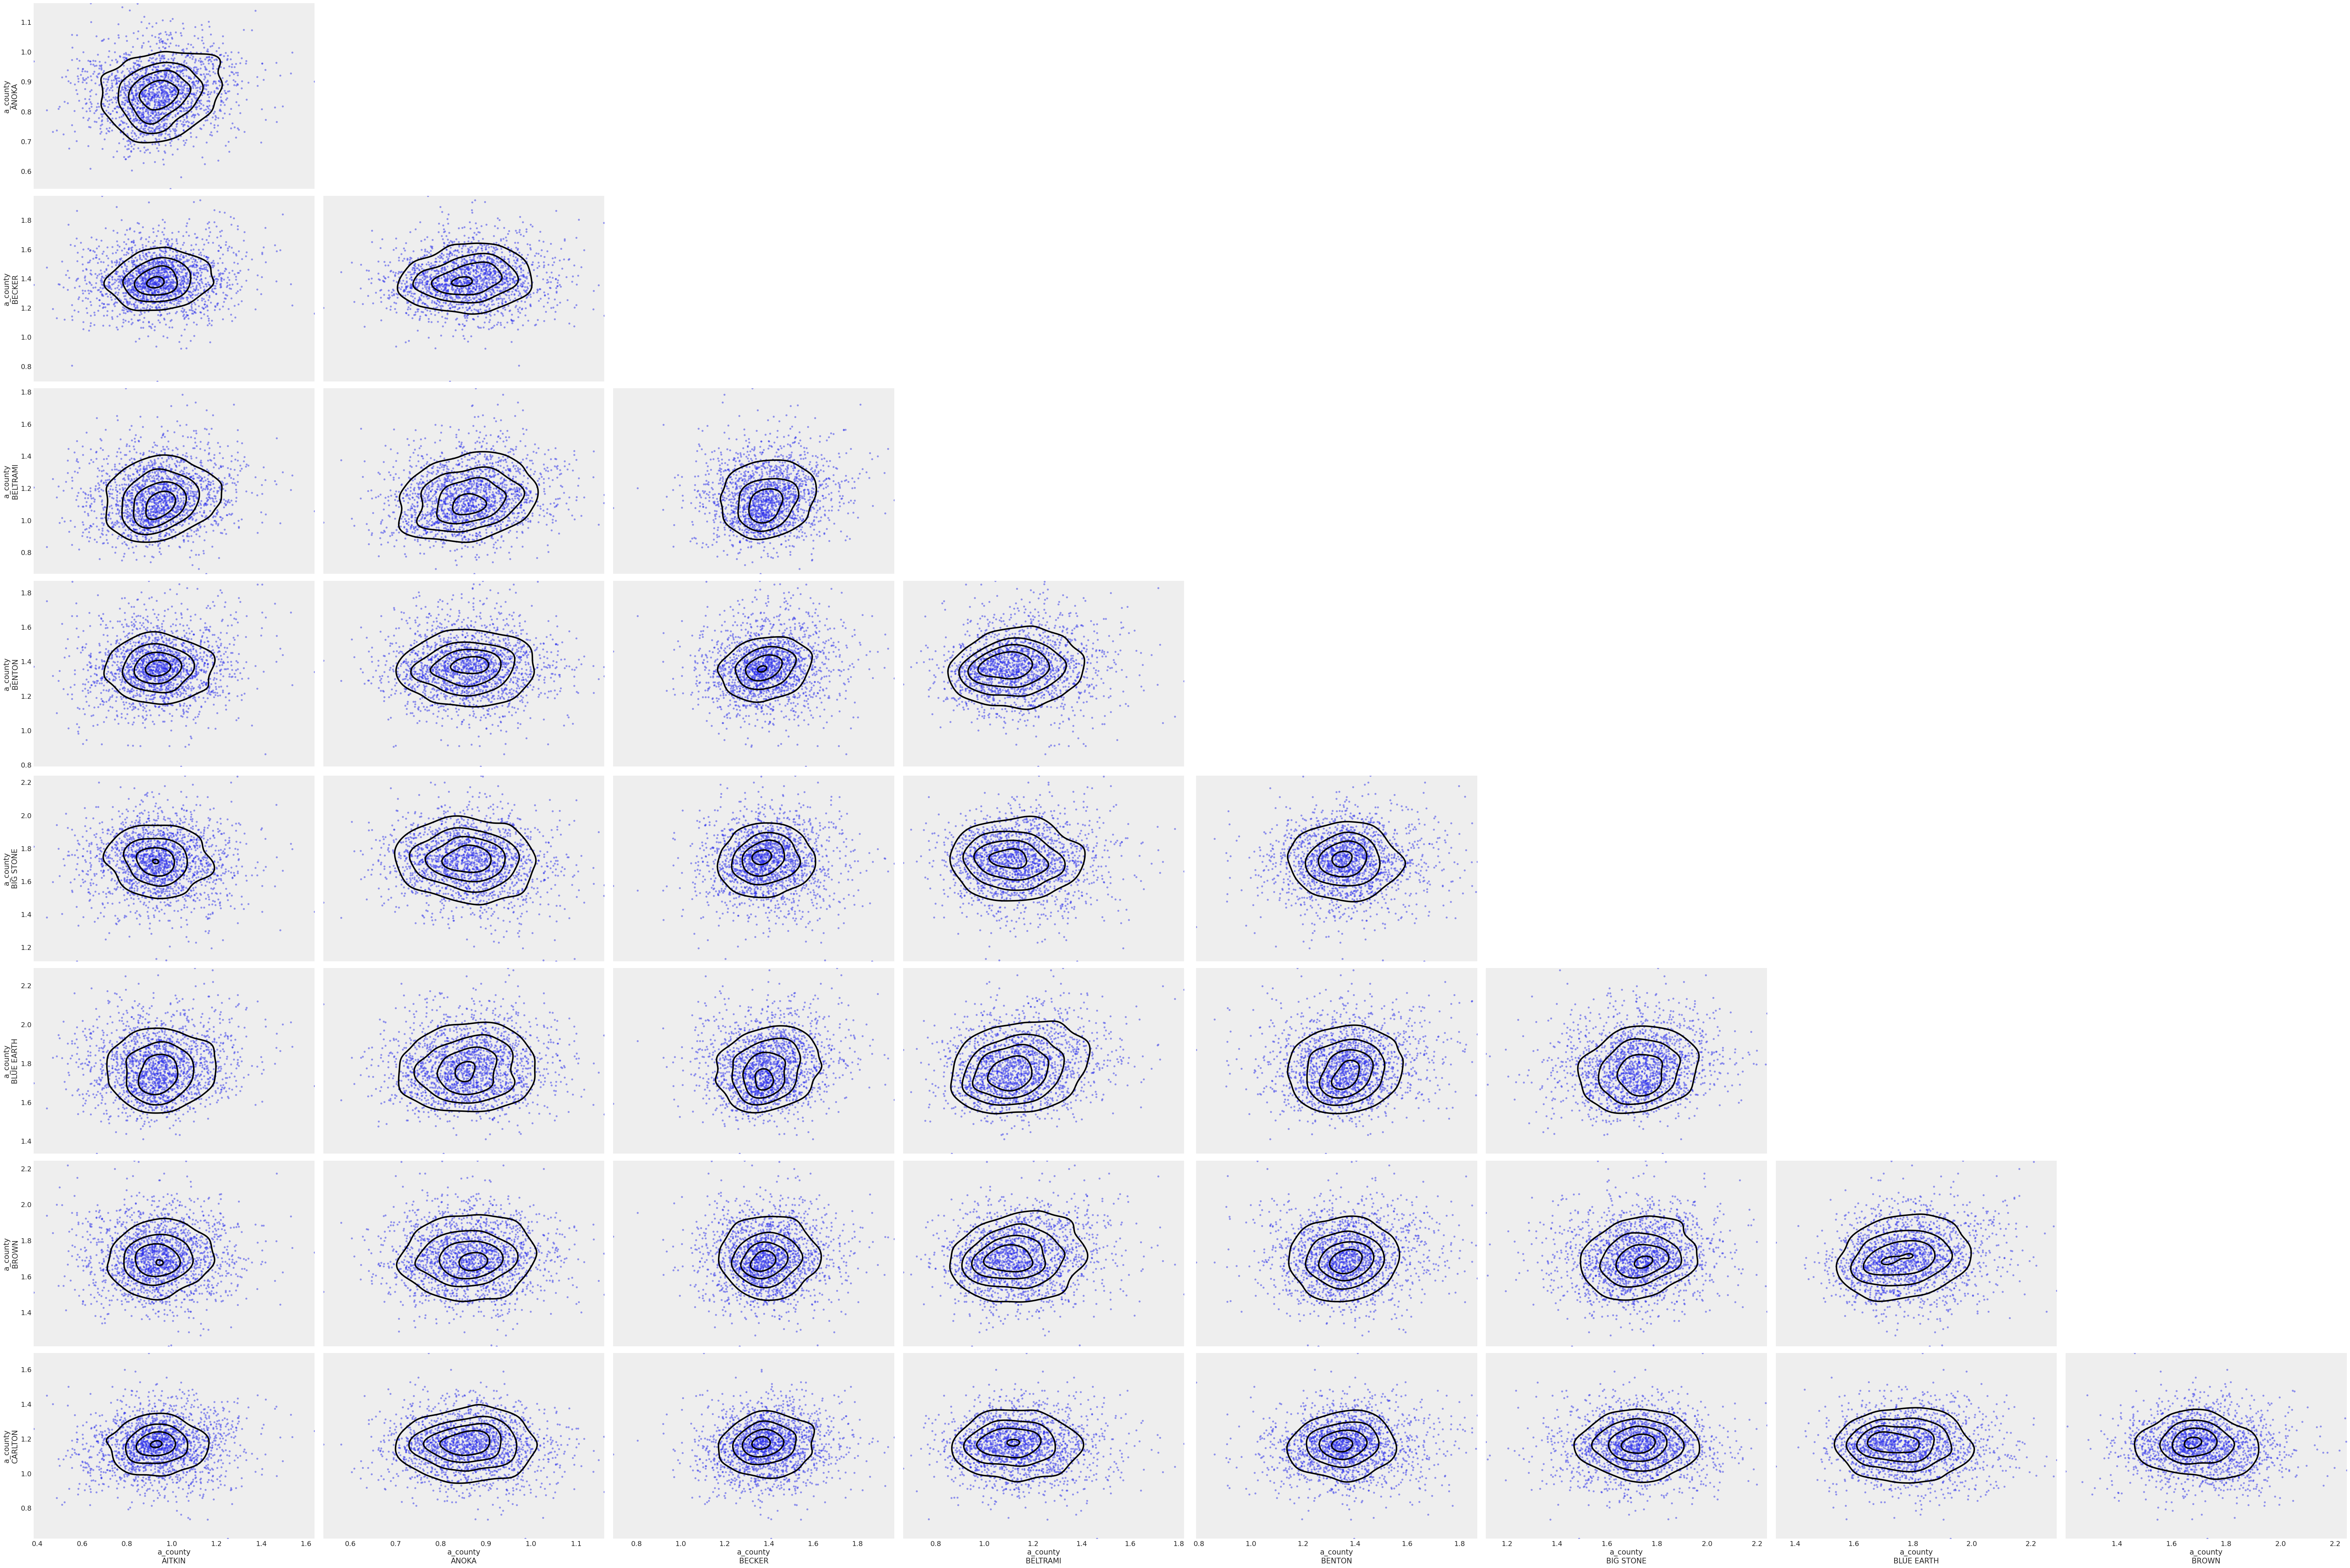

In [28]:
az.plot_pair(
    idata, 
    var_names="a_county", 
    kind=["scatter", "kde"], 
    scatter_kwargs={"alpha": .4}, 
    kde_kwargs={"contour_kwargs": {"colors": "k", "linewidths": 3, "levels": 4}}
);